# Random Forest Mode - Best Model Metaparameters

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import math
import pandas
import numpy
import itertools
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB

In [12]:
import loan_approval_lib
from loan_approval_lib import logspace, linspace

In [13]:
from kaggle_wrapper_lib import kaggle_competition_submit
from kaggle_wrapper_lib import kaggle_competition_submissions

In [14]:
from loan_approval_lib.standard_data_processing import data_cleaning_algorithm
from loan_approval_lib.standard_data_processing import create_loan_grade_numerical_from_loan_grade
from loan_approval_lib.standard_data_processing import create_person_home_ownership_one_hot_encoder
from loan_approval_lib.standard_data_processing import create_person_home_ownership_one_hot
from loan_approval_lib.standard_data_processing import create_loan_intent_one_hot_encoder
from loan_approval_lib.standard_data_processing import create_loan_intent_one_hot
from loan_approval_lib.standard_data_processing import map_cb_person_default_on_file
from loan_approval_lib.standard_data_processing import create_decision_tree_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns_with_id
from loan_approval_lib.standard_data_processing import create_dataframe_copy_and_drop_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns_with_id

In [15]:
data = loan_approval_lib.load_original_data()

In [16]:
data_train = loan_approval_lib.load_data_train()

In [17]:
data_test = loan_approval_lib.load_data_test()

# Data Cleaning, Data Preprocessing

In [18]:
data = data_cleaning_algorithm(data)

column person_age, number of removed rows: 5
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 897
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 3047
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [19]:
data_train = data_cleaning_algorithm(data_train)

column person_age, number of removed rows: 1
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 2
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 0
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [20]:
data_cleaning_algorithm(data_test)
None

column person_age, number of removed rows: 0
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 0
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 0
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [21]:
# Loan Grade

create_loan_grade_numerical_from_loan_grade(data, data_train, data_test)

In [22]:
# Person Home Ownership

encoder = create_person_home_ownership_one_hot_encoder(data)

data = create_person_home_ownership_one_hot(encoder, data)
data_train = create_person_home_ownership_one_hot(encoder, data_train)
data_test = create_person_home_ownership_one_hot(encoder, data_test)

In [23]:
# Loan Intent

encoder = create_loan_intent_one_hot_encoder(data)

data = create_loan_intent_one_hot(encoder, data)
data_train = create_loan_intent_one_hot(encoder, data_train)
data_test = create_loan_intent_one_hot(encoder, data_test)

In [24]:
# Default On File

data = map_cb_person_default_on_file(data)
data_train = map_cb_person_default_on_file(data_train)
data_test = map_cb_person_default_on_file(data_test)

# Choose Columns for Tree Model, Copy DataFrame and Drop Unused Columns

In [25]:
decision_tree_columns = create_decision_tree_columns()
decision_tree_columns_with_id = create_decision_tree_columns_with_id()

In [26]:
MAX_FEATURES = len(decision_tree_columns)
MAX_FEATURES

19

In [27]:
data_copy = create_dataframe_copy_and_drop_columns(data)
data_train_copy = create_dataframe_copy_and_drop_columns(data_train)
data_test_copy = create_dataframe_copy_and_drop_columns(data_test)

# Random Forest Model

In [28]:
def random_forest_model_train(
    data_train,
    decision_tree_columns,
    n_estimators,
    max_features,
    max_depth,
    min_samples_split,
    min_samples_leaf,
    max_leaf_nodes,
    bootstrap,
    n_jobs,
):

    X = data_train[decision_tree_columns].copy()
    Y = data_train['loan_status'].copy()
    
    clf = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        criterion='entropy',
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        bootstrap=bootstrap,
        oob_score=True,
        n_jobs=n_jobs,
        
    )
    clf.fit(X, Y)
    
    Z = clf.predict(X)
    X['loan_status_predict'] = Z
    X['loan_status'] = data_train['loan_status']
    accuracy_in_sample = (X['loan_status'] == X['loan_status_predict']).sum() / len(X)
    
    return (clf, accuracy_in_sample)

In [29]:
def random_forest_model_test(
    clf,
    data_test,
    decision_tree_columns,
):

    X_test = data_test[decision_tree_columns].copy()

    Z_test = clf.predict(X_test)
    X_test['loan_status_predict'] = Z_test
    X_test['loan_status'] = data_test['loan_status']
    accuracy_out_of_sample = (X_test['loan_status'] == X_test['loan_status_predict']).sum() / len(X_test)
    
    return accuracy_out_of_sample

In [30]:
def decision_tree_model_predict_proba(
    clf,
    data_test,
    decision_tree_columns,
):

    X_test = data_test[decision_tree_columns].copy()

    Z_test = clf.predict_proba(X_test)[:, 1]

    return Z_test

In [84]:
def decision_tree_model_test_AUC_tpr_fpr(
    clf,
    data_test,
    decision_tree_columns,
):
    
    # create threshold array
    # this code creates `threshold_array`, and it is sorted in ascending order
    
    #data_predict = decision_tree_model_predict(
    #    clf,
    #    data_test,
    #    decision_tree_columns,
    #    decision_tree_columns_with_id,
    #)
    
    #threshold_array = numpy.concatenate(
    #    (
    #        numpy.array([-numpy.inf]),
    #        numpy.unique(data_predict['loan_status']),
    #        numpy.array([1.1]),
    #    )
    #)

    # use threshold array to calculate TPR and FPR
    #count = len(threshold_array)

    #tpr_array = numpy.zeros(shape=(count,), dtype=float)
    #fpr_array = numpy.zeros(shape=(count,), dtype=float)
    
    #for i, threshold in enumerate(threshold_array):
    #    (tpr, fpr) = decision_tree_model_test_TPR_FPR(
    #        clf,
    #        data_test,
    #        decision_tree_columns,
    #        threshold,
    #    )
    
    #    threshold_array[i] = threshold
    #    tpr_array[i] = tpr
    #    fpr_array[i] = fpr
    
    #sort_index = numpy.argsort(fpr_array)
    #tpr_array = tpr_array[sort_index]
    #fpr_array = fpr_array[sort_index]
    #threshold_array = threshold_array[sort_index]

    # calculate threshold array, TPR and FPR
    (roc_curve_fpr, roc_curve_tpr, roc_curve_threshold) = roc_curve(
        data_test['loan_status'],
        decision_tree_model_predict_proba(clf, data_test, decision_tree_columns),
    )
    # may not include the -inf and +inf bounds?

    # use TPR and FPR to calculate AUC
    #roc_auc = auc(fpr_array, tpr_array)
    roc_auc = auc(roc_curve_fpr, roc_curve_tpr)
    
    return (roc_auc, roc_curve_tpr, roc_curve_fpr)

In [32]:
def random_forest_model_predict(
    clf,
    data_predict,
    decision_tree_columns,
    decision_tree_columns_with_id,
):
    
    X_predict = data_predict[decision_tree_columns_with_id].copy()

    Z_predict = clf.predict_proba(X_predict[decision_tree_columns])
    X_predict['loan_status'] = Z_predict[:, 1]

    return X_predict

In [33]:
def random_forest_model_predict_write_to_csv(
    data_predict,
    filename,
):
    data_predict[['id', 'loan_status']].to_csv(filename, index=False)

# Optimize Choice of Dataset

In [34]:
len(data_copy), len(data_train_copy), len(data_test_copy)

(28632, 58642, 39098)

In [35]:
'loan_status' in data_copy.columns, 'loan_status' in data_train_copy.columns, 'loan_status' in data_test_copy

(True, True, False)

In [36]:
28632 + 58642

87274

In [37]:
all_training_data = pandas.concat(
    [data_copy, data_train_copy],
    axis=0,
)
all_training_data.reset_index(inplace=True, drop=True)

In [38]:
permutation = numpy.random.permutation(all_training_data.index)

In [39]:
n_samples = len(all_training_data)
n_samples

87274

In [40]:
k = 100

In [41]:
fold_sizes = numpy.full(k, n_samples // k, dtype=int)

In [42]:
fold_sizes[:n_samples % k] += 1

In [43]:
index = 0
folds = []
for fold_size in fold_sizes:
    start = index
    stop = index + fold_size
    folds.append(permutation[start:stop])
    index = stop

In [44]:
def kaggle_competition_submit_and_get_public_private_score_sync(filename, message):
    
    _ = kaggle_competition_submit(
        filename,
        message_tag
    )

    # TODO: Can make this faster with async logic
    while True:
        submissions = kaggle_competition_submissions()
        filtered_submissions = submissions[submissions['description'] == message_tag]
        assert len(filtered_submissions) == 1, f'invalid number of filtered submissions {len(filtered_submissions)}'
        status = filtered_submissions['status'][0]
        if status == 'SubmissionStatus.COMPLETE':
            break
        elif status == 'SubmissionStatus.PENDING':
            pass
        else:
            print(f'status={status}')

    public_score = filtered_submissions['publicScore'][0]
    private_score = filtered_submissions['privateScore'][0]

    return (public_score, private_score)

In [45]:
MAX_FEATURES

19

In [105]:
n_estimators = 100
max_features = 11 #10 #None #5 # maximized at 11?
max_depth = 18 #None #10 # best appears to be about 18
min_samples_split = 10 #2. similar to below, looks good at 10
min_samples_leaf = 10 #1. set to 10, AUC maximized for 1, but in sample shows good performance for 10
max_leaf_nodes = None # leave this on none, AUC maximized by None

In [106]:
n_cpu = 16

#filename = 'random_forest_3_best_model-estimators_100.csv'
filename = 'random_forest_3_best_model-estimators_100-max_features_11-max_depth_18-min_samples_split_10-min_samples_leaf_10.csv'

In [107]:
n_estimators_list = []
max_features_list = []
max_depth_list = []
min_samples_split_list = []
min_samples_leaf_list = []
max_leaf_nodes_list = []
fold_list = []
accuracy_in_sample_list = []
accuracy_out_of_sample_list = []
oob_score_list = []
auc_list = []
tpr_list = []
fpr_list = []
public_score_list = []
private_score_list = []

df = None

for i in range(k):
    
    test_index = folds[i]
    train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])

    training_data = all_training_data.loc[train_index]
    test_data = all_training_data.loc[test_index]
    
    (
        clf,
        accuracy_in_sample,
    ) = random_forest_model_train(
        training_data,
        decision_tree_columns,
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        bootstrap=True,
        n_jobs=n_cpu,
    )

    oob_score_ = clf.oob_score_

    accuracy_out_of_sample = random_forest_model_test(
        clf,
        test_data,
        decision_tree_columns,
    )

    (auc_, tpr, fpr) = decision_tree_model_test_AUC_tpr_fpr(
        clf,
        test_data,
        decision_tree_columns,
    )

    public_score = numpy.nan
    private_score = numpy.nan
    
    n_estimators_list.append(float(n_estimators))
    max_features_list.append(float(max_features) if max_features is not None else numpy.nan)
    max_depth_list.append(float(max_depth) if max_depth is not None else numpy.nan)
    min_samples_split_list.append(float(min_samples_split))
    min_samples_leaf_list.append(float(min_samples_leaf))
    max_leaf_nodes_list.append(float(max_leaf_nodes) if max_leaf_nodes is not None else numpy.nan)
    fold_list.append(i)
    accuracy_in_sample_list.append(accuracy_in_sample)
    accuracy_out_of_sample_list.append(accuracy_out_of_sample)
    oob_score_list.append(oob_score_)
    auc_list.append(auc_)
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    public_score_list.append(public_score)
    private_score_list.append(private_score)

    data_predict = random_forest_model_predict(
        clf,
        data_test_copy,
        decision_tree_columns,
        decision_tree_columns_with_id,
    )
    
    df = pandas.DataFrame(
        {
            'estimators': n_estimators_list,
            'max_features': max_features_list,
            'max_depth': max_depth_list,
            'min_samples_split': min_samples_split_list,
            'min_samples_leaf': min_samples_leaf_list,
            'max_leaf_nodes': max_leaf_nodes_list,
            'fold': fold_list,
            'accuracy_in_sample': accuracy_in_sample_list,
            'accuracy_out_of_sample': accuracy_out_of_sample_list,
            'oob_score': oob_score_list,
            'auc': auc_list,
            'public_score': public_score_list,
            'private_score': private_score_list,
        }
    )
    df.to_csv(filename, index=True)

In [108]:
df

,estimators,max_features,max_depth,min_samples_split,min_samples_leaf,max_leaf_nodes,fold,accuracy_in_sample,accuracy_out_of_sample,oob_score,auc,public_score,private_score
0,100.0,11.0,18.0,10.0,10.0,NaN,0,0.949040,0.958763,0.946204,0.968010,NaN,NaN
1,100.0,11.0,18.0,10.0,10.0,NaN,1,0.948762,0.936999,0.946285,0.955963,NaN,NaN
2,100.0,11.0,18.0,10.0,10.0,NaN,2,0.948681,0.954181,0.946054,0.957854,NaN,NaN
3,100.0,11.0,18.0,10.0,10.0,NaN,3,0.949260,0.927835,0.946424,0.946213,NaN,NaN
4,100.0,11.0,18.0,10.0,10.0,NaN,4,0.949156,0.946163,0.945996,0.959990,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,100.0,11.0,18.0,10.0,10.0,NaN,95,0.948890,0.940367,0.946089,0.935655,NaN,NaN
96,100.0,11.0,18.0,10.0,10.0,NaN,96,0.949145,0.927752,0.946182,0.940212,NaN,NaN
97,100.0,11.0,18.0,10.0,10.0,NaN,97,0.948936,0.946101,0.946136,0.939078,NaN,NaN
98,100.0,11.0,18.0,10.0,10.0,NaN,98,0.949087,0.955275,0.946112,0.953025,NaN,NaN


In [51]:
df = pandas.read_csv(filename, index_col=0)

# Plot Results

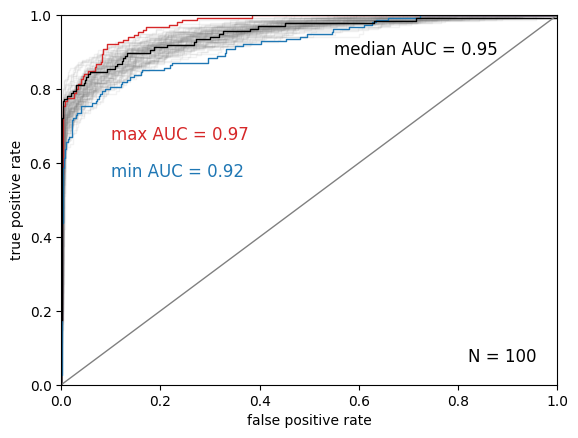

In [119]:
plt.figure()

auc_median_exact = numpy.median(auc_list)
auc_min = numpy.min(auc_list)
auc_max = numpy.max(auc_list)

index_median = numpy.argsort(auc_list)[len(auc_list)//2]
index_min = numpy.argsort(auc_list)[0]
index_max = numpy.argsort(auc_list)[-1]

#auc_median = # not required

tpr_min = tpr_list[index_min]
tpr_max = tpr_list[index_max]
fpr_min = fpr_list[index_min]
fpr_max = fpr_list[index_max]
tpr_median = tpr_list[index_median]
fpr_median = fpr_list[index_median]

for iteration in range(len(auc_list)):
    auc_ = auc_list[iteration]
    fpr_ = fpr_list[iteration]
    tpr_ = tpr_list[iteration]

    if iteration == index_min:
        continue
    if iteration == index_max:
        continue
    if iteration == index_median:
        continue

    plt.step(fpr_, tpr_, where='post', linewidth=1, linestyle='solid',
         label=f'{iteration} (AUC={auc_:.2f})',
         color='grey',
         alpha=0.1)

# max, red
plt.step(fpr_max, tpr_max, where='post', linewidth=1, linestyle='solid',
         label=f'{iteration} (AUC={auc_max:.2f})',
         color='tab:red',
         alpha=1.0)

# min, blue
plt.step(fpr_min, tpr_min, where='post', linewidth=1, linestyle='solid',
         label=f'{iteration} (AUC={auc_min:.2f})',
         color='tab:blue',
         alpha=1.0)

# median, black
plt.step(fpr_median, tpr_median, where='post', linewidth=1, linestyle='solid',
         label=f'{iteration} (AUC={auc_median_exact:.2f})',
         color='black',
         alpha=1.0)

plt.plot([0.0, 1.0], [0.0, 1.0], color='grey', linewidth=1)

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

# AUC min
plt.text(
    0.10,
    0.60,
    f'min AUC = {auc_min:.2f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    color='tab:blue',
)

# AUC max
plt.text(
    0.10,
    0.70,
    f'max AUC = {auc_max:.2f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    color='tab:red',
)

# N = 100
plt.text(
    0.82,
    0.10,
    f'N = 100',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
)

# AUC median
plt.text(
    0.55,
    0.93,
    f'median AUC = {auc_median_exact:.2f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
)

#plt.savefig('random_forest_3_best_model-ROC-k-fold-all-estimators_100.png')
#plt.savefig('random_forest_3_best_model-ROC-k-fold-all-estimators_100.pdf')

#plt.savefig('random_forest_3_best_model-ROC-k-fold-all-estimators_100-max_features_10.png')
#plt.savefig('random_forest_3_best_model-ROC-k-fold-all-estimators_100-max_features_10.pdf')

#plt.savefig('random_forest_3_best_model-ROC-k-fold-all-max_features_5-max_depth_10.png')
#plt.savefig('random_forest_3_best_model-ROC-k-fold-all-max_features_5-max_depth_10.pdf')

plt.savefig('random_forest_3_best_model-ROC-k-fold-all-estimators_100-max_features_11-max_depth_18-min_samples_split_10-min_samples_leaf_10.png')
plt.savefig('random_forest_3_best_model-ROC-k-fold-all-estimators_100-max_features_11-max_depth_18-min_samples_split_10-min_samples_leaf_10.pdf')

None

# Plot AUC distribution, in sample, out of sample, oob and accuracy as a function of threshold

# Kaggle Submission

In [111]:
(
    clf,
    accuracy_in_sample,
) = random_forest_model_train(
    all_training_data,
    decision_tree_columns,
    n_estimators=n_estimators,
    max_features=max_features,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_leaf_nodes=max_leaf_nodes,
    bootstrap=True,
    n_jobs=n_cpu,
)

oob_score_ = clf.oob_score_

#accuracy_out_of_sample = random_forest_model_test(
#    clf,
#    test_data,
#    decision_tree_columns,
#)

#(auc_, tpr, fpr) = decision_tree_model_test_AUC_tpr_fpr(
#    clf,
#    test_data,
#    decision_tree_columns,
#)

# TODO plot tpr,fpr (can't: no test data)

data_predict = random_forest_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

random_forest_model_predict_write_to_csv(
    data_predict,
    filename='random_forest_3_best_model-ROC-k-fold-all-estimators_100-max_features_11-max_depth_18-min_samples_split_10-min_samples_leaf_10.csv',
)

In [116]:
data_predict[['id', 'loan_status']]

,id,loan_status
0,58645,0.992515
1,58646,0.040863
2,58647,0.482209
3,58648,0.016442
4,58649,0.095635
...,...,...
39093,97738,0.126904
39094,97739,0.010141
39095,97740,0.007938
39096,97741,0.228309


In [118]:
data_predict['id'].isna().sum()

np.int64(0)